## Import libraries

In [ ]:
pip install pydicom


     |████████████████████████████████| 2.0 MB 25.1 MB/s 


In [ ]:
import pydicom
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# # select file from laptop
# from google.colab import files
# uploaded = files.upload()

## Access the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/StrokeProject/BrainScans/vhf.1502.dcm"
outputpath = "content/drive/MyDrive/StrokeProject/BrainScans_processed"

In [ ]:
medical_image = pydicom.read_file(filepath)

In [ ]:
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.75064541463040.2005072610432302976
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: Secondary Capture Image Storage
(0002, 0016) Source Application Entity Title     AE: 'GDCM'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20050726'
(0008, 0013) Instance Creation Time              TM: '104323'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.750

References:

* [Index dicom data](https://escapetech.eu/manuals/qmedical/commands/index_DICOM_Data.html)

* [Pydicom dataset](https://pydicom.github.io/pydicom/stable/reference/generated/pydicom.dataset.Dataset.html#pydicom.dataset.Dataset.group_dataset)

In [ ]:
image = medical_image.pixel_array

In [ ]:
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

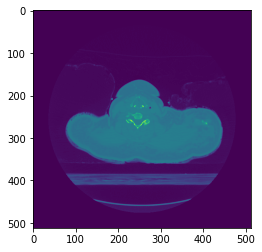

In [ ]:
plt.imshow(image, cmap="viridis")

In [ ]:
image.shape

(512, 512)

In [ ]:
# range of values of the image
print(image.min())
print(image.max())

0
2483


References:
* [Digital Image Processing ](http://www.sprawls.org/resources/DIGPROCESS/module.htm#1)

**Changing Image Charactereistics with processing:**

*1. Reduce image noise*

*2. Increase visiblity of detail*

*3. Adjust and opimtize the image contrast characteristics*

**Processing steps:**

*1. Transofrming to HU & windowing*

*2. Removing noises & adjusting the size*

*3. Tilt correction*

*4. Cropping and padding*

*5. Resampling*

## Transform to HU x Windowing


**The Hounsfield Scale (HU):**


*This is a 'relative quantitative measurement of the intensity of radio waves used by radiologists for better explanation and understanding of CT images'.*

*The denser the tissue, the greater the X-ray beam absorption which gives off a brighter appearance and a positive number on the HU scale*

*Therefeore, the bones will appear brighter than the tissues*

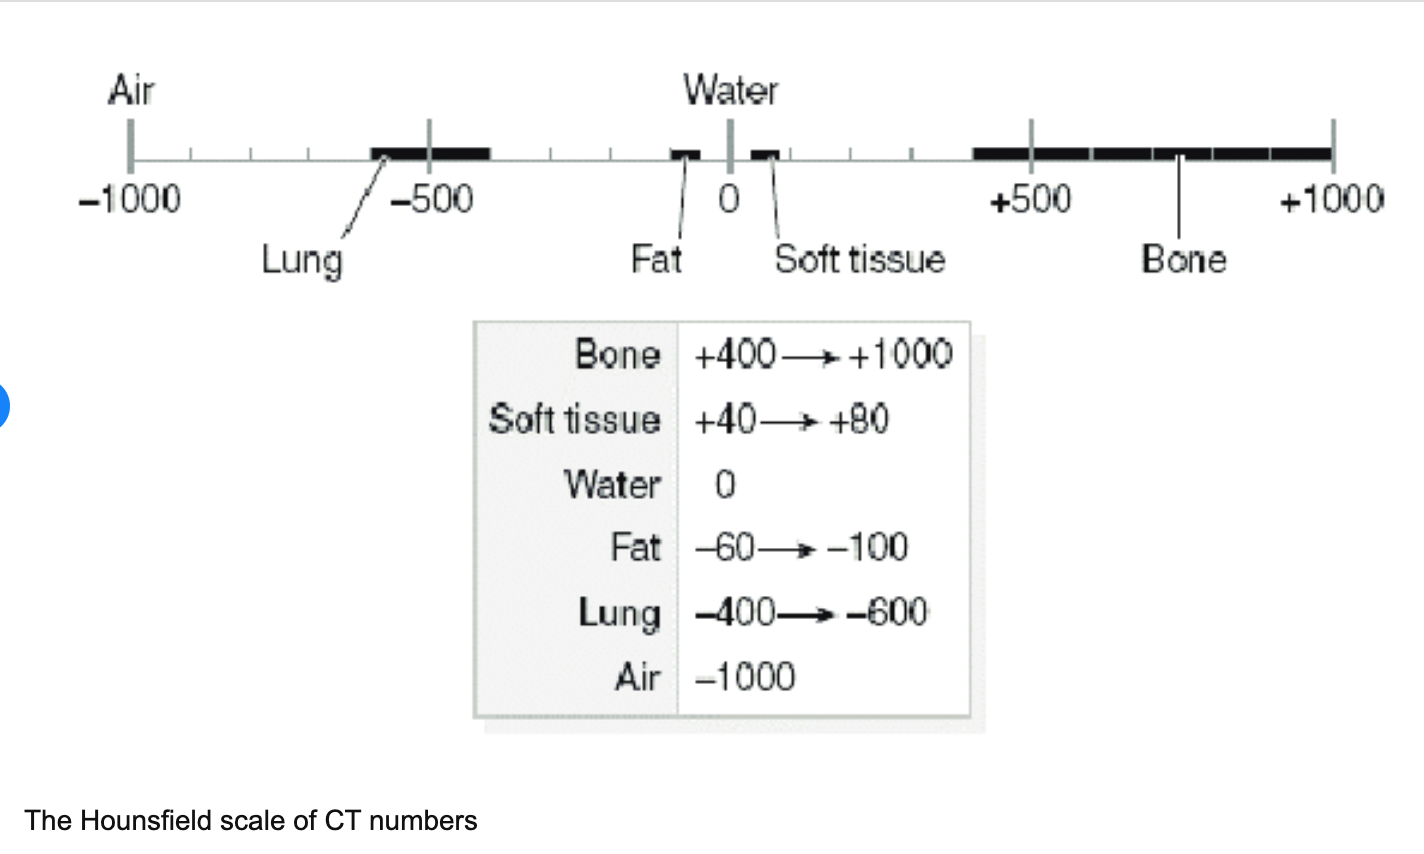

References:
* [Dicom rescale-intercept and rescale-slope](https://www.kitware.com/dicom-rescale-intercept-rescale-slope-and-itk/#:~:text=Rescale%20intercept%2C%20(0028%7C1052,to%20their%20in%20memory%20representation.&text=where%20U%20is%20in%20output,b%20is%20the%20rescale%20intercept.)

* [Window width and center calculations](https://stackoverflow.com/questions/8756096/window-width-and-center-calculation-of-dicom-image/8765366#8765366)

* [Values of Interest](https://escapetech.eu/manuals/qmedical/commands/index_Values_of_Interest__.html)

**Rescale intercept and rescale slope:**

*They specify the linear transformation from pixels in their stores in disk representation to their in memeory representations*


*Pixel values only have meaning to the device that generated them.*


*This means that rescale intercept and slope   allow the transormation of the original pixel values to other knwon measurements.*


**Window width x window center:**

*The values obtained after **wc - ww // 2** are mapped to 0*


*while the values obtained after **wc + ww // 2** are mapped to 255*

In [ ]:
def transform_to_hu (medical_image, image):
  intercept = medical_image.RescaleIntercept
  slope = medical_image.RescaleSlope
  hu_image = image * slope + intercept

  return hu_image

In [ ]:
# def display_hu_histogram(hu_image):
#   image_to_process = np.load(image).astype(np.float64)

#   plt.hist(image_to_process.flatten(), bins=50, color='c')
#   plt.xlabel("Hounsfield Units (HU)")
#   plt.ylabel("Frequency")
#   plt.show()

#   return hu_image

In [ ]:
def window_image (image, window_center, window_width):
  img_min = window_center - window_width // 2   #these values are mapped to 0
  img_max = window_center + window_width // 2   #these values are mapped to 255
  window_image = image.copy()
  window_image[window_image < img_min] = img_min
  window_image[window_image > img_max] = img_max

  return window_image

In [ ]:
hu_image = transform_to_hu(medical_image, image)
soft_tissue_image = window_image(hu_image, 40, 80)
bone_image = window_image(hu_image, 300, 1000)
water_image = window_image(hu_image, -60, 40)

(-0.5, 511.5, 511.5, -0.5)

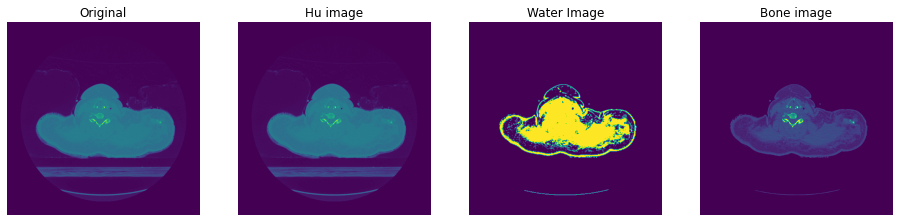

In [ ]:
# plt.figure(figsize=(16,8))
# plt.imshow(hu_image, cmap="viridis")

plt.figure(figsize=(20, 10))
# plt.style.use(cmap="viridis")cmap="viridis"

plt.subplot(151)
plt.imshow(image, cmap="viridis")
plt.title('Original')
plt.axis('off')

plt.subplot(152)
plt.imshow(hu_image, cmap="viridis")
plt.title('Hu image')
plt.axis('off')

plt.subplot(154)
plt.imshow(bone_image, cmap="viridis")
plt.title('Bone image')
plt.axis('off')

plt.subplot(153)
plt.imshow(water_image, cmap="viridis")
plt.title('Water Image')
plt.axis('off')


# reference : https://nbviewer.org/github/vincent1bt/Healthy-notebooks/blob/master/CT_images.ipynb

In [ ]:
# plt.figure(figsize=(16,8))
# plt.imshow(soft_tissue_image, cmap="viridis")

In [ ]:
# plt.figure(figsize=(16,8))
# plt.imshow(bone_image, cmap="viridis")

In [ ]:
# plt.figure(figsize=(16,8))
# plt.imshow(water_image, cmap="viridis")

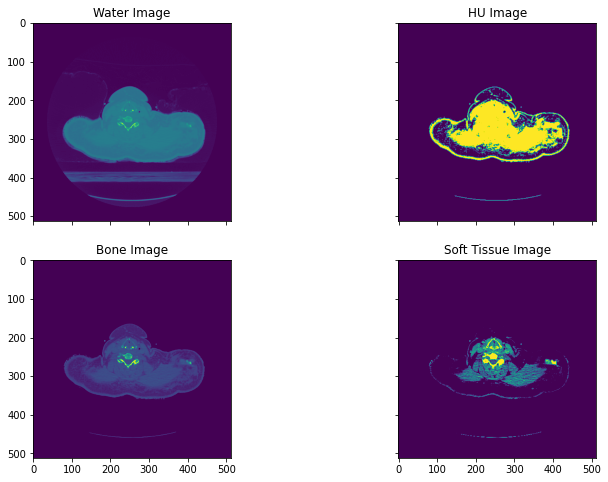

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(12,8))
axarr[0, 0].imshow(image, cmap="viridis")
axarr[0, 0].set_title('Water Image')
axarr[0, 1].imshow(water_image, cmap="viridis")
axarr[0, 1].set_title('HU Image')
axarr[1, 0].imshow(bone_image, cmap="viridis")
axarr[1, 0].set_title('Bone Image')
axarr[1, 1].imshow(soft_tissue_image, cmap="viridis")
axarr[1, 1].set_title('Soft Tissue Image')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()

Reference: [Subplots and figure size](https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots)

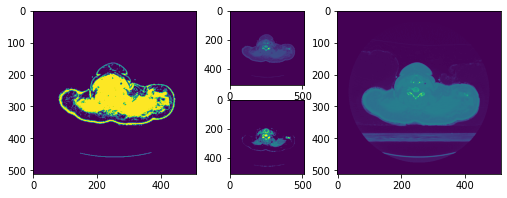

In [ ]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax3 = f.add_subplot(211)
ax4 = f.add_subplot(212)
x = np.linspace(0,4,1000)
ax.imshow(water_image, cmap="viridis")
ax2.imshow(hu_image, cmap="viridis")
ax3.imshow(bone_image, cmap="viridis")
ax4.imshow(soft_tissue_image, cmap="viridis")


Reference : [A-Matter-Of-Grayscale-Understanding-Dicom-Windows](https://asvcode.github.io/MedicalImaging/medical_imaging/windowing/dicoms/2020/11/04/A-Matter-Of-Grayscale-Understanding-Dicom-Windows.html)

## Removing Noises x Adjusting the Size

## Tilt Correction

## Cropping and Padding

## Resampling

## References


Dataset source : https://medicine.uiowa.edu/mri/facility-resources/images/visible-human-project-ct-datasets

Tutorial sources:
* [Medical Images in Python (CT)](https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography)

* [Medical Image preprocessing with python](https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606)

* [Comprehensive guide to visualizing and analyzing dicom images in python](https://hengloose.medium.com/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed)

* [Downloading and pre processing medical images in bulk - dicom to numpy with python](https://glassboxmedicine.com/2021/02/16/downloading-and-preprocessing-medical-images-in-bulk-dicom-to-numpy-with-python/)

* [Understanding DICOMS](https://towardsdatascience.com/understanding-dicoms-835cd2e57d0b)

* [Medical Imaging](https://asvcode.github.io/MedicalImaging/)

* [DICOM Processing and Segmentation in Python](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)